In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD
from altaipony.wheatland import calculate_joint_posterior_distribution, gaussian_prior



for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

In [2]:
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))


In [4]:
#df = pd.read_csv("../k2scoc/results/tables/full_table.csv")
# df1 = pd.read_csv("../k2scoc/results/tables/full_table.csv")
# df2 = pd.read_csv("../k2scoc/results/tables/lost_table.csv")
# df = pd.concat([df1,df2])
df = pd.read_csv("../k2scoc/results/tables/2020_05_final_flares.csv")

hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
df = df[hasflares  | wassearched]


In [5]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
df = df[(df.Teff_median<=6000) & (df.Teff_median>=2500)]
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates() 
tobs = cepic.LC_time_years.sum()

print(f"Total observing time: {tobs:.2f} years!")
labels = ["2500-3000","3000-3250","3250-3500",
          "3500-3750","3750-4000","4000-5000",
          "5000-6000"]
Mmid  = [0.097, .19, .36, .47, .55, .71, .94]
masses = pd.DataFrame({"Teff_median" : labels,
                       "M_Msun" : Mmid})

params = pd.read_csv("cluster_parameters_merged.csv")


bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
T = T.merge(masses, how="left", on="Teff_median")
T = T.merge(params[["cluster","age (Myr)"]], how="left", on="cluster")
assert T.LC_time_years.sum() - tobs < 1e-10
T.head()

Total observing time: 615.34 years!


,Teff_median,cluster,LC_time_years,M_Msun,age (Myr)
0,2500-3000,hyades,3.201118,0.097,690.0
1,2500-3000,ngc2682,NaN,0.097,3639.0
2,2500-3000,ngc6774,NaN,0.097,2650.0
3,2500-3000,pleiades,9.734428,0.097,135.0
4,2500-3000,praesepe,4.740475,0.097,750.0


# Davenport 2019 Gyro-flare model

In [6]:
def gyroflaremodel(t, m):
    '''From table in Davenport+2019'''
    a1, a2, a3 = -.07, .79, -1.06
    b1, b2, b3 = 2.01, -25.15, 33.99
    alpha = a1 * np.log10(t) + a2 * m + a3
    beta = b1 * np.log10(t) + b2 * m + b3
    return np.array([alpha, beta, t, m])


s = T.apply(lambda x: gyroflaremodel(x["age (Myr)"], x["M_Msun"]), axis=1)
s = pd.DataFrame(s.tolist(), columns=['alpha', 'beta', "age (Myr)", "M_Msun"])
T = T.merge(s, how="left", on=[ "age (Myr)", "M_Msun"])
T.dropna(how="any").tail()

,Teff_median,cluster,LC_time_years,M_Msun,age (Myr),alpha,beta
30,5000-6000,hyades,1.413358,0.94,690.0,-0.516119,16.055087
31,5000-6000,ngc2682,42.053730,0.94,3639.0,-0.566669,17.506574
32,5000-6000,ngc6774,6.491958,0.94,2650.0,-0.557027,17.229724
33,5000-6000,pleiades,14.005932,0.94,135.0,-0.466523,14.630971
34,5000-6000,praesepe,41.611054,0.94,750.0,-0.518654,16.127873


# Full sample FFD plots with $E_\mathrm{kp}$ and $ED$


In [7]:
resfullsample = {}

959
959


100%|██████████| 200/200 [00:03<00:00, 58.35it/s]


Fitted power law alpha=2.0953421311629397(0.03534345248088089/0.035450428520654054)
Fitted power law beta=1989.0934286947365(598.0186715293246/458.66276196581316)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


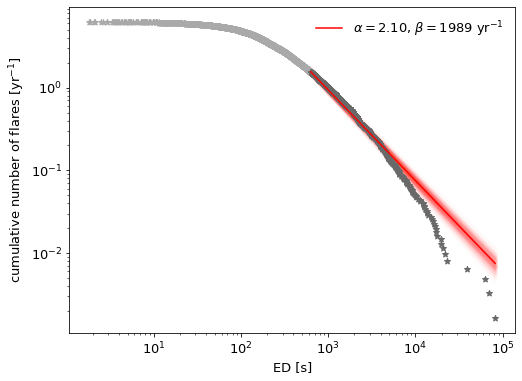

In [8]:
fig, ax =  plt.subplots(1, figsize=(8,6))

hasflares = (df.real==1) & (df.todrop.isnull())
ffd = FFD(f=df[hasflares], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="darkgrey", marker="*")#, label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min() * 2.
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]
print(len(ffd.ed))
ffd.alpha_prior = 1.99
ffd.beta_prior = 981.75
BFA = ffd.fit_mcmc_powerlaw(steps=200)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")

ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300, linewidth=5, c="tomato", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="*", c="dimgrey", )#label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="r", 
                            label=(fr"$\alpha=${ffd.alpha:.2f}, "
                                   fr"$\beta=${int(np.rint(ffd.beta))}" + r" yr$^{-1}$"))

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("ED [s]")
plt.ylabel(r"cumulative number of flares [yr$^{-1}$]")

resfullsample["alpha"] = ffd.alpha
resfullsample["alpha_up_err"] = ffd.alpha_up_err
resfullsample["alpha_low_err"] = ffd.alpha_low_err
resfullsample["beta"] = ffd.beta
resfullsample["beta_up_err"] = ffd.beta_up_err
resfullsample["beta_low_err"] = ffd.beta_low_err
resfullsample["nflares_tot"] = len(ed)
resfullsample["nflares_for_fit"] = len(ffd.ed)
resfullsample["ispowerlaw"] = ispowerlaw
resfullsample["istruncated"] = truncated

plt.savefig(f"plots/{tstamp}_full_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_ED_wheatland.png", dpi=300)

In [9]:
thresh

629.354014491578

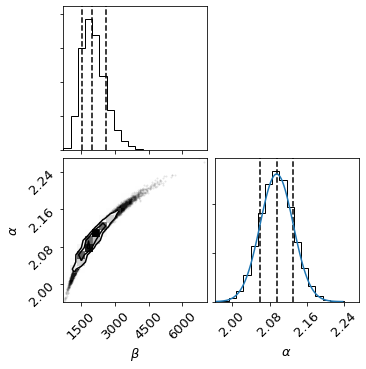

In [13]:
BFA.show_corner_plot(show_truths=False, show_titles=False)


x = np.linspace(resfullsample["alpha"] - resfullsample["alpha_low_err"]*4,
                resfullsample["alpha"] + resfullsample["alpha_up_err"]*4,100)
plt.plot(x, 465*gaussian_prior(x, resfullsample["alpha"], 
                            (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.))
plt.savefig(f"plots/{tstamp}_full_ED_FFD_cornerplot.png", dpi=300)

In [14]:
def loglikelihood_gauss_wheatland_ed(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha"], 
                           (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

In [16]:
with open(f"{paperdir}values/gauss_wheatland_alpha_mu.txt", "w") as f:
    f.write(str(resfullsample["alpha"]))
with open(f"{paperdir}values/gauss_wheatland_alpha_sigma.txt", "w") as f:
    f.write(str((resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.))

1213


100%|██████████| 200/200 [00:03<00:00, 53.19it/s]


Fitted power law alpha=1.9850317483859161(0.028094568961731348/0.02789459684776241)
Fitted power law beta=4.160090380914767e+32(3.174266626883464e+33/3.6710918436192115e+32)


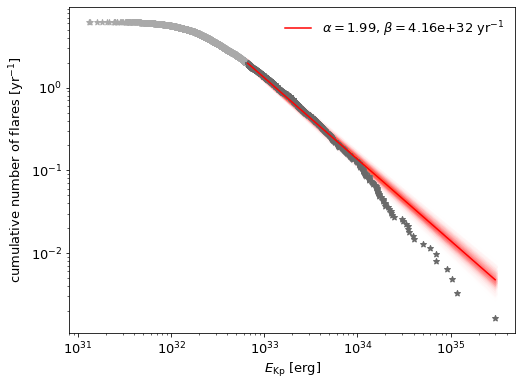

In [15]:
fig, ax =  plt.subplots(1, figsize=(8,6))
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
ffd = FFD(f=df2[hasflares & ~(df.ed_rec.isnull())], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="darkgrey", marker="*")#, label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min() * 2.

ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]

ffd.alpha_prior = 1.85
ffd.beta_prior = 1.75e28
BFA = ffd.fit_mcmc_powerlaw(steps=200.)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300,linewidth=5, c="tomato", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="*", c="dimgrey")#, label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="r", label=fr"$\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}"  + r" yr$^{-1}$")


resfullsample["alpha_en"] = ffd.alpha
resfullsample["alpha_up_err_en"] = ffd.alpha_up_err
resfullsample["alpha_low_err_en"] = ffd.alpha_low_err
resfullsample["beta_en"] = ffd.beta
resfullsample["beta_up_err_en"] = ffd.beta_up_err
resfullsample["beta_low_err_en"] = ffd.beta_low_err
resfullsample["nflares_tot_en"] = len(ed)
resfullsample["nflares_for_fit_en"] = len(ffd.ed)
resfullsample["ispowerlaw_en"] = ispowerlaw
resfullsample["istruncated_en"] = truncated

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel(r"$E_\mathrm{Kp}$ [erg]")
plt.ylabel(r"cumulative number of flares [yr$^{-1}$]")

plt.savefig(f"plots/{tstamp}_full_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_energy_wheatland.png", dpi=300)

In [ ]:
thresh

In [ ]:
BFA.show_corner_plot(show_truths=False, show_titles=False)
x = np.linspace(resfullsample["alpha_en"] - resfullsample["alpha_low_err_en"]*4,
                resfullsample["alpha_en"] + resfullsample["alpha_up_err_en"]*4,100)
plt.plot(x, 385*gaussian_prior(x, resfullsample["alpha_en"], 
                            (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.))
plt.savefig(f"plots/{tstamp}_full_energy_FFD_cornerplot.png", dpi=300)

In [ ]:
def loglikelihood_gauss_wheatland_energy(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha_en"], 
                           (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

In [ ]:
_t = pd.Series(resfullsample)
resfulltab =  pd.DataFrame({"space": [r"$ED$", r"$E_\mathrm{Kp}$"],
              r"$\alpha$":[f"${_t.alpha:.2f}\left(OK1{_t.alpha_up_err:.2f}K2UK1{_t.alpha_up_err:.2f}K2\right)$",
                           f"${_t.alpha_en:.2f}\left(OK1{_t.alpha_up_err_en:.2f}K2UK1{_t.alpha_up_err_en:.2f}K2\right)$",],
              r"$\beta$ [yr$^{-1}$]":[f"${int(np.rint(_t.beta))}\left(OK1{int(np.rint(_t.beta_up_err))}K2UK1{int(np.rint(_t.beta_low_err))}K2\right)$",
                          f"${_t.beta_en/10**32:.2f}\left(OK1{_t.beta_up_err_en/10**32:.2f}K2UK1{_t.beta_low_err_en/10**32:.2f}K2\right)" + r"\cdot 10^{32}$"],
              r"$n_\mathrm{tot}$":[_t.nflares_tot,_t.nflares_tot_en,],
              r"$n_\mathrm{fit}$":[_t.nflares_for_fit,_t.nflares_for_fit_en,],
             # r"$tr$":[_t.istruncated,_t.istruncated_en,],
             # r"$pl$":[_t.ispowerlaw,_t.ispowerlaw_en,]
             })
_t.to_csv("tables/full_sample_alphabeta.csv")

In [ ]:
resfulltab[r"$\alpha$"] = (resfulltab[r"$\alpha$"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

resfulltab[r"$\beta$ [yr$^{-1}$]"] = (resfulltab[r"$\beta$ [yr$^{-1}$]"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))
names = resfulltab['space'].values
resfulltab = resfulltab.T

resfulltab = resfulltab.rename(index=str, columns=dict(zip(resfulltab.columns.values, names)))
resfulltab = resfulltab.drop("space")
nc = 'c' * (resfulltab.shape[1])
stri = resfulltab.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
stri = stri.replace("{}"," " )

with open(f"{paperdir}tables/powerlaw_fullsample_wheatland.tex", "w") as f:
    f.write(stri)

print(stri)

In [ ]:
with open(f"{paperdir}values/MCMC_alpha_ed.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha"],2)))
with open(f"{paperdir}values/MCMC_alpha_energy.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha_en"],2)))

## Teff bins


In [ ]:
labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"]
bins_T = pd.cut(df["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
numer = ["a.","b.","c.","d.","e.","f.","g."]

In [ ]:
resed = {}

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,19.5), sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df.groupby(bins_T):
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades","praesepe","ngc6774", "ngc2682"],
                      ordered=True)
    resed[i]={}
    for j, h in g.groupby("cluster"):

        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha"]
            ffd.beta_prior = resfullsample["beta"]

            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_ed)
            print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
            print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
            
                
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            resed[i][ccol[j][0]]={"alpha":ffd.alpha,
                                  "alpha_up_err":ffd.alpha_up_err,
                                  "alpha_low_err":ffd.alpha_low_err,
                                  "beta":ffd.beta,
                                  "beta_up_err":ffd.beta_up_err,
                                  "beta_low_err":ffd.beta_low_err,
                                  "nflares":len(ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw":ffd.is_powerlaw(),
                                  "istruncated": ffd.is_powerlaw_truncated()
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)

            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                            label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.0f}" + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(1, 1.1e5)
            axes[k].set_xlabel(r"$ED$ [s]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            if k==6:
                axes[k].legend(loc=1)
            else:
                axes[k].legend(loc=3)

            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)

In [ ]:
resen = {}
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12.5,19.5),
                         sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]

for i, g in df2.groupby(bins_T):
    resen[i]={}
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades",
                                  "praesepe","ngc6774",
                                  "ngc2682"],
                      ordered=True)
    for j, h in g.groupby("cluster"):
        tobs = T[(T.Teff_median == i) &
                 (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha_en"]
            ffd.beta_prior = resfullsample["beta_en"]
            
            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_energy)
            print(f"Fitted power law alpha={ffd.alpha:.2f}({ffd.alpha_up_err:.2f}/{ffd.alpha_low_err:.2f})")
            print(f"Fitted power law beta={ffd.beta:.2e}({ffd.beta_up_err:.2e}/{ffd.beta_low_err:.2e})")
            
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            # Add Davenport model
            ab = T[(T.cluster==j) & (T.Teff_median==i)]
            A = 1. - ab.alpha.iloc[0]
            B = np.power(10, ab.beta.iloc[0]) * (A - 1.) * 365.25
            ffdd = FFD(alpha=A, beta=B)
            ffdd.ed = ffd.ed
            if len(ffdd.ed) == 1:
                ffdd.ed = [ffdd.ed/2.,ffdd.ed*2.]
            a, x, y = ffdd.plot_powerlaw(axes[k], c=ccol[j][1], linewidth=3)
            # ----------------------------------------------------------------
            resen[i][ccol[j][0]]= {"alpha_en":ffd.alpha,
                                  "alpha_up_err_en":ffd.alpha_up_err,
                                  "alpha_low_err_en":ffd.alpha_low_err,
                                  "beta_en":ffd.beta,
                                  "beta_up_err_en":ffd.beta_up_err,
                                  "beta_low_err_en":ffd.beta_low_err,
                                  "nflares_en":len(ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw_en":ffd.is_powerlaw(),
                                  "istruncated_en": ffd.is_powerlaw_truncated(),
                                  "davenport_alpha": A,
                                  "davenport_beta":B,
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}"   + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(8e30, 5e35)
            axes[k].set_xlabel(r"$E_\mathrm{Kp}$ [erg]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            axes[k].legend(loc=3)
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)

In [ ]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in resed.items() for innerKey, values in innerDict.items()}

betaed_ = pd.DataFrame(reform).T
betaed = betaed_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                          "level_1":"cluster"}) 

reform = {(outerKey, innerKey): values for outerKey, innerDict in resen.items() for innerKey, values in innerDict.items()}

betaen_ = pd.DataFrame(reform).T
betaen = betaen_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})
beta = betaed.merge(betaen)
beta["Tmin"] = beta.Teff.apply(lambda x: int(x.split("-")[0]))
beta["Tmax"] = beta.Teff.apply(lambda x: int(x.split("-")[1]))
beta["Tmid"] = ((beta.Tmax + beta.Tmin) / 2).astype(int)
beta["Tmid_err"] = ((beta.Tmax - beta.Tmin) / 2).astype(int)
beta.to_csv("tables/cluster_SpT_alphabeta.csv",index=False)
beta.sort_values(by="nflares")

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["x","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    ax.errorbar(x=g.age, xerr=g[["age_uperr","age_lowerr"]].values.T,
                 y=g.beta, yerr=g[["beta_up_err","beta_low_err"]].values.T,
                 label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",c=Tcols[str(label)][1],
                  marker=Tcols[str(label)][0],markersize=10)
#     g.plot(x="age", xerr="age_uperr",y="beta",yerr="beta_err",
#            label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K", ax=ax, kind="line",c=Tcols[str(label)][1],
#           marker=Tcols[str(label)][0],markersize=10)#s=120,)#
    

ax.set_xlabel("age [Myr]")
ax.set_ylabel(r"$\beta_\mathrm{s}$ [yr$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(beta.age.astype(float).unique())
ax.set_xticklabels(labels=beta.age.unique(), rotation=90)
ax.set_ylim(1,2e4)
ax.legend(loc=(1.03,.5))
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_beta_T_age_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/beta_T_age_ED_wheatland.png", dpi=300)

In [ ]:
beta_s = betaen_.merge(betaed_, left_index=True,right_index=True)
for b in ["beta","beta_up_err","beta_low_err",
          "beta_en","beta_up_err_en", "beta_low_err_en"]:
    beta_s.loc[:,b] = beta_s[b].astype(float)


for out, beta, beta_up_err, beta_low_err in [(r"$\beta_\mathrm{s}$","beta","beta_up_err", "beta_low_err"),
                                             (r"$\beta_\mathrm{erg}$","beta_en","beta_up_err_en", "beta_low_err_en"),
                                           
                            ]:
    if out == r"$\beta_\mathrm{erg}$":
        beta_s["perr"] = (np.rint(np.log10(beta_s[beta]/beta_s[beta_up_err]))+2).astype(int)
        beta_s["b"] = (np.rint(np.log10(beta_s[beta]))).astype(int)
        beta_s["berr"] = (np.rint(np.log10(beta_s[beta_up_err]))).astype(int)
        beta_s["B"] = beta_s.apply(lambda x: np.round(x[beta]/10**x.b, x.perr).astype(str), axis=1)
        beta_s["Berr_up"] = beta_s.apply(lambda x: np.round(x[beta_up_err]/10**x.b, x.perr), axis=1)     
        beta_s["Berr_low"] = beta_s.apply(lambda x: np.round(x[beta_low_err]/10**x.b, x.perr), axis=1) 
    
        beta_s[out] = beta_s.apply(lambda x: f"${x.B}\left(OK1{x.Berr_up}K2UK1{x.Berr_low}K2\right)\cdot 10OK1{x.b}K2$", axis=1)
    else: 
        beta_s[out] = beta_s.apply(lambda x: f"${int(x[beta])}\left(OK1{int(x[beta_up_err])}K2UK1{int(x[beta_low_err])}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

    
for out, beta, beta_up_err, beta_low_err in [(r"$\alpha_\mathrm{erg}$","alpha_en","alpha_up_err_en", "alpha_low_err_en"),
                                             (r"$\alpha_\mathrm{s}$","alpha","alpha_up_err", "alpha_low_err"),
                            ]:    
    beta_s[out] = beta_s.apply(lambda x: f"${x[beta]:.2f}\left(OK1{x[beta_up_err]:.2f}K2UK1{x[beta_low_err]:.2f}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))    
    
rename = {"nflares":r"$n$",#_\mathrm{s}$",
         #"nflares_en":r"$n_\mathrm{erg}$",
        #  "istruncated":r"$tr_\mathrm{s}$",
        # "istruncated_en":r"$tr_\mathrm{erg}$",
        # "ispowerlaw":r"$pl_\mathrm{s}$",
        # "ispowerlaw_en":r"$pl_\mathrm{erg}$",
         }
beta_s = beta_s[[r"$\alpha_\mathrm{s}$",r"$\beta_\mathrm{s}$",#"nflares_en",#"istruncated","ispowerlaw",,"istruncated_en","ispowerlaw_en"
                 r"$\alpha_\mathrm{erg}$",r"$\beta_\mathrm{erg}$","nflares"]].rename(index=str, columns=rename)
beta_s = beta_s.sort_index()
nc = 'c' * (beta_s.shape[1])
stri = beta_s.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
stri = stri.replace("\hline\n          &         &    ", "\hline\n $T_{eff}$ [K] & cluster &")
with open(f"{paperdir}tables/powerlaw_SpT_wheatland.tex", "w") as f:
    f.write(stri)

# Notes on very old clusters

## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- 219341906 - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, CWW79
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

In [ ]:

df[(df.cluster=="ngc2682") & (df.real==1) & (df.Teff_median<6000)].dropna(subset=["real"])[["dtp_tot", "EPIC","C",
                                                                    "Teff_median", "ed_rec","note", 
                                                                    "todrop", "real"]]

In [ ]:
3449/2/24

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- 211390071 - It's an SSO! 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- 211396661 - It's an SSO! 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [ ]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).Teff_median

# Compare Shibayama 2013 Kepler superflares to our flares

In [ ]:
ens = np.linspace(5e33,5e34,200000)
#ens = np.linspace(5e34,5e35,200000)
1 / np.sum(np.power(ens[:-1]*.72,-1.85) * 2.05e27 / .85 *np.diff(ens))  #M67
365.25 / np.sum(np.power(ens[:-1]*.72,-1.85) * 5.2e28 / .85 *np.diff(ens))  # Pleiades

In [ ]:
1/800, 1/5000

In [ ]:
800/18, 5000/128

In [ ]:
np.power(1e34,-1.85) * 2.05e27 / .85

In [ ]:
18-130 

## OLD paper vs. NEW paper

In [ ]:
def f(alpha, beta, E):
    return np.power(10,beta) / (alpha-1) * np.power(E,-alpha+1)

In [ ]:
f(1.87, np.log10(.5e29), 1e33)

In [ ]:
resed